In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import scanpy as sc
sc.settings.n_jobs = 56
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

import sys
sys.path.append('/home/xingjiepan/Softwares/ZhuangLab/MERFISH_analysis/basic/util')
from plot import get_color_mapping_df, make_frameless_scatter_plot

In [2]:
import re

def sort_slice_name(slice_names):
    slices = []
    
    for sn in slice_names:
        m = re.search('(.+)_slice([0-9]+)', sn)
        slices.append((m.group(1), int(m.group(2)), sn))    
    
    sorted_slices = sorted(slices, key=lambda x:(x[0], x[1]))
    return [x[2] for x in sorted_slices]

def plot_all_slices(adata_obs, slice_col, color_col, dot_size=1, slices=None,
                    fig_width=3):
    if None is slices:
        slices = sort_slice_name(np.unique(adata_obs[slice_col]))
    
    N_cols = 5
    N_rows = int(np.ceil(len(slices) / N_cols))

    fig, axes = plt.subplots(N_rows, N_cols, figsize=(fig_width * N_cols, fig_width * N_rows), dpi=200)
    if len(axes.shape) == 1:
        axes = np.array([axes])
    
    for i in range(N_rows):    
        
        for j in range(N_cols):
            idx = N_cols * i + j
            if idx >= len(slices):
                axes[i, j].set_axis_off()
                continue
                
            adata_tmp_obs = adata_obs[adata_obs[slice_col] == slices[idx]]
            axes[i, j].scatter(adata_tmp_obs['center_x'], adata_tmp_obs['center_y'], 
                            c=adata_tmp_obs[color_col], s=dot_size, marker='.',
                            edgecolor='none', rasterized=True)
            
            axes[i, j].set_aspect('equal')
            axes[i, j].set_title(slices[idx])
            axes[i, j].set_axis_off()

def random_color_cell_types(adata_obs, cell_type_col, color_col):
    cell_types  = np.unique(adata_obs[cell_type_col])
    ct_ids = np.array(list(range(len(cell_types))))
    random_colors_rgb = np.random.uniform(size=(len(ct_ids), 3))
    random_colors = [matplotlib.colors.to_hex(rgb) for rgb in random_colors_rgb]
    color_mapping_df = pd.DataFrame({'cell_type': cell_types, 'colors':random_colors}).set_index('cell_type')

    color_mapping_df_merged = adata_obs[[cell_type_col]].merge(
                                    color_mapping_df, 
                                    left_on=cell_type_col, right_index=True, how='left')
    adata_obs[color_col] = color_mapping_df_merged['colors']

In [3]:
adata = sc.read_h5ad('adata_spatial_modules_level_1.h5ad')

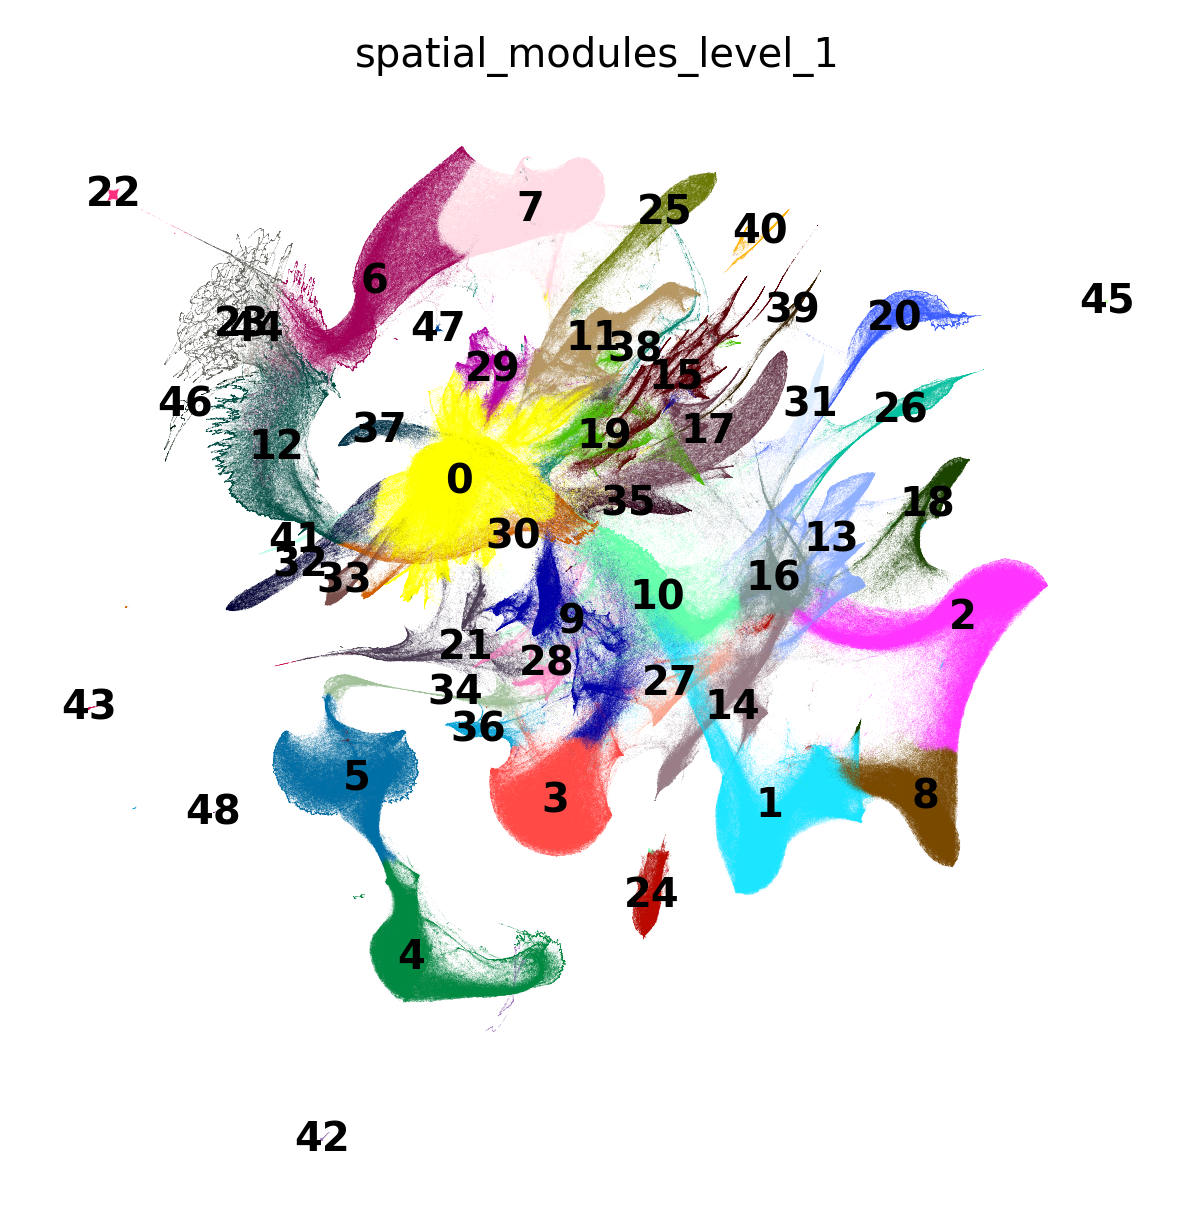

In [4]:
sc.pl.umap(adata, color='spatial_modules_level_1', legend_loc='on data')

In [ ]:
random_color_cell_types(adata.obs, 'spatial_modules_level_1', 'sm1_color')
make_frameless_scatter_plot(adata.obsm['X_umap'][:, 0], 
                            adata.obsm['X_umap'][:, 1], 
                            adata.obs['sm1_color'], size=0.01)

In [ ]:
selected_sms = ['9', '28']
local_ct_mask = adata.obs['spatial_modules_level_1'].isin(selected_sms)

local_colors = np.array(adata.obs['sm1_color'])
local_colors[~local_ct_mask] = '#99999911'

adata.obs['local_color'] = local_colors
adata_display = adata.obs[adata.obs['slice_id'].str.startswith('co1')]

plot_all_slices(adata_display, 'slice_id', 'local_color', dot_size=2)

In [61]:
# Annotate the spatial modules
sm_anno_map = {
    'SM_MOB inner': ['5', '48'],
    'SM_MOB outer': ['4', '42'],
    'SM_OLF/HPF': ['13', '14', '16', '20', '24', '26', '27', '31', '45'],
    'SM_CTX': ['1', '2', '8'],
    'SM_RSP': ['18'],
    'SM_STR': ['3', '36'],
    'SM_PAL/STR': ['9', '28'],
    'SM_TH':['17', '39'],
    'SM_RT': ['35'],
    'SM_HY': ['15'],
    'SM_MB': ['11', '19', '25'],
    'SM_HB': ['0', '29', '32', '33', '37', '40', '41', '47'],
    'SM_CB': ['6', '7'],
    'SM_CB/FT': ['12', '22', '23', '44', '46'],
    'SM_FT': ['10', '30', '38'],
    'SM_VS': ['21', '34', '43'],
    }

spatial_modules_level_1_names = np.array(['SmallAndUndefined'] * adata.shape[0])

for smn in sm_anno_map:
    spatial_modules_level_1_names[adata.obs['spatial_modules_level_1'].isin(sm_anno_map[smn])] = smn
    
adata.obs['spatial_modules_level_1_name'] = spatial_modules_level_1_names

In [62]:
np.unique(spatial_modules_level_1_names)

array(['SM_CB', 'SM_CB/FT', 'SM_CTX', 'SM_FT', 'SM_HB', 'SM_HY', 'SM_MB',
       'SM_MOB inner', 'SM_MOB outer', 'SM_OLF/HPF', 'SM_PAL/STR',
       'SM_RSP', 'SM_RT', 'SM_STR', 'SM_TH', 'SM_VS'], dtype='<U17')

<AxesSubplot:>

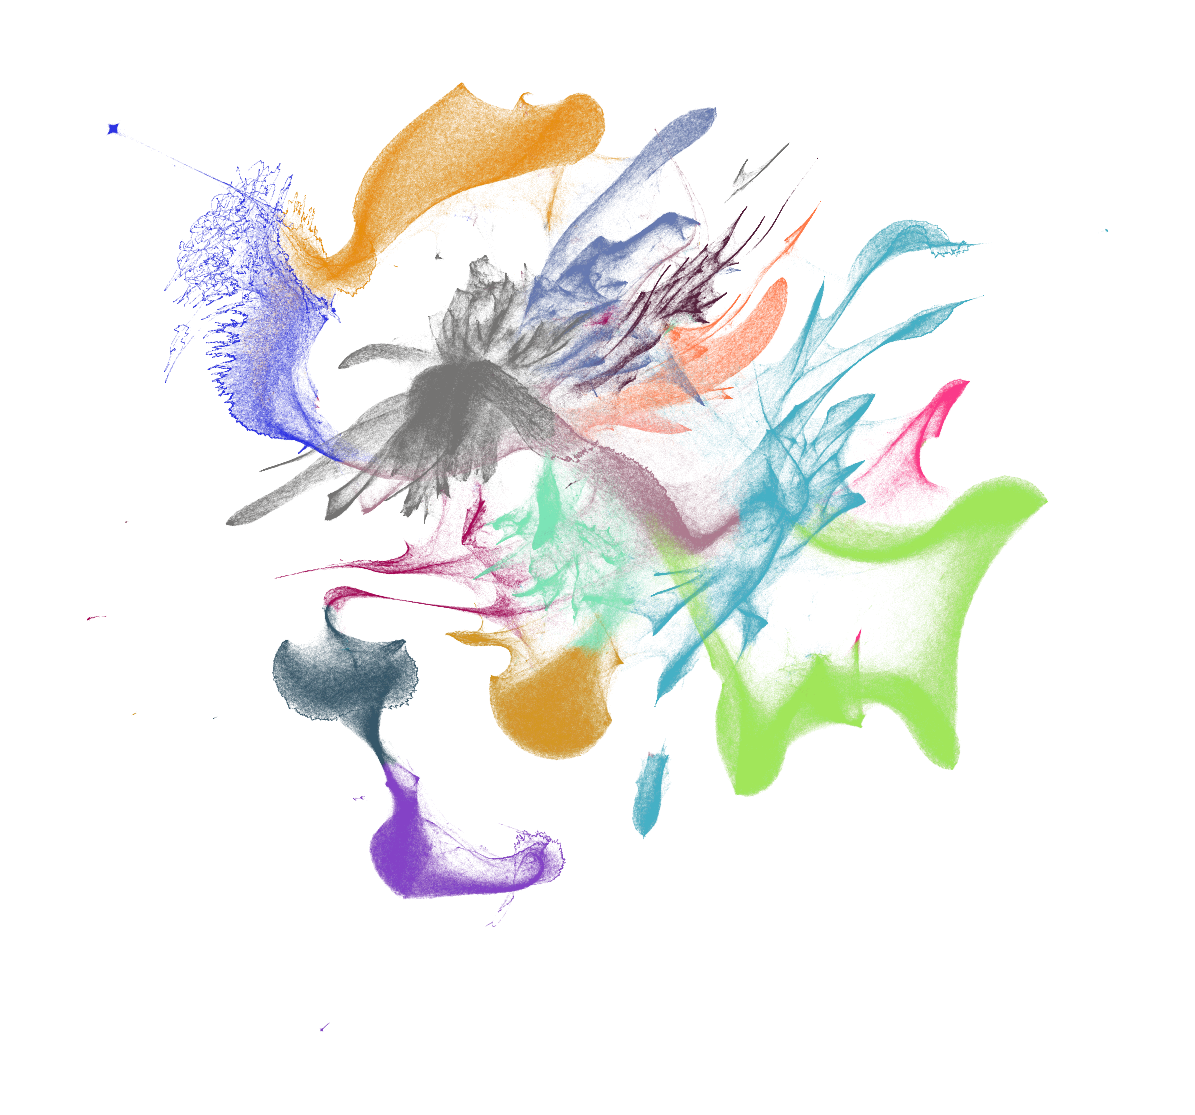

In [63]:
random_color_cell_types(adata.obs, 'spatial_modules_level_1_name', 'sm1n_color')
make_frameless_scatter_plot(adata.obsm['X_umap'][:, 0], 
                            adata.obsm['X_umap'][:, 1], 
                            adata.obs['sm1n_color'], size=0.01)

In [ ]:
plot_all_slices(adata.obs, 'slice_id', 'sm1n_color', dot_size=1)

In [65]:
adata.write('adata_spatial_modules_level_1_annotated.h5ad')

In [66]:
adata.obs.to_csv('cell_metadata_spatial_module_level1.csv')